In [2]:
import os
import zipfile
import shutil

# =================================================================
# COLAB CELL 1: Install Kaggle API and Set Up Authentication
# =================================================================

# We start by installing the official Kaggle command-line tool.
print("--- CELL 1: Installing Kaggle API ---")
# Using pip to install the package
os.system("pip install kaggle --quiet")
print("Kaggle API installed successfully.")

# Authentication Instructions (Crucial Step for the User)
print("\n--- ACTION REQUIRED: Kaggle Authentication ---")
print("Before proceeding, you must upload your Kaggle API token (kaggle.json).")
print("1. Go to Kaggle (kaggle.com) -> Your Profile -> Account.")
print("2. Under the API section, click 'Create New API Token'. This downloads 'kaggle.json'.")
print("3. Upload the 'kaggle.json' file to your Colab session's root directory (or /root/.kaggle/) now.")
print("   (You can use the 'Files' icon on the left sidebar of Colab for easy upload.)")
print("4. We will now ensure the file is in the correct location: /root/.kaggle/")

# Create the .kaggle directory if it doesn't exist
os.makedirs('/root/.kaggle', exist_ok=True)

# Attempt to move or copy the kaggle.json file to the correct location for the CLI to find it.
# The user must ensure kaggle.json is uploaded to the Colab environment first.
try:
    # This assumes the user uploaded kaggle.json to the Colab working directory
    shutil.move('kaggle.json', '/root/.kaggle/kaggle.json')
    # Set necessary permissions
    os.chmod('/root/.kaggle/kaggle.json', 0o600)
    print("kaggle.json moved and permissions set successfully.")
except FileNotFoundError:
    print("WARNING: 'kaggle.json' not found in the current working directory.")
    print("Please ensure you upload your 'kaggle.json' file and run this cell again.")

--- CELL 1: Installing Kaggle API ---
Kaggle API installed successfully.

--- ACTION REQUIRED: Kaggle Authentication ---
Before proceeding, you must upload your Kaggle API token (kaggle.json).
1. Go to Kaggle (kaggle.com) -> Your Profile -> Account.
2. Under the API section, click 'Create New API Token'. This downloads 'kaggle.json'.
3. Upload the 'kaggle.json' file to your Colab session's root directory (or /root/.kaggle/) now.
   (You can use the 'Files' icon on the left sidebar of Colab for easy upload.)
4. We will now ensure the file is in the correct location: /root/.kaggle/
kaggle.json moved and permissions set successfully.


In [3]:
# COLAB CELL 2: Download the Dataset
# =================================================================

DATASET_SLUG = "samuelcortinhas/cats-and-dogs-image-classification"
DOWNLOAD_FILE = DATASET_SLUG.split('/')[-1] + '.zip'
DATA_DIR = 'cats_and_dogs_data'

print(f"\n--- CELL 2: Downloading Dataset: {DATASET_SLUG} ---")
print("Initiating download via Kaggle CLI...")

# Execute the Kaggle command to download the dataset
# -d flag specifies the dataset slug
os.system(f"kaggle datasets download -d {DATASET_SLUG}")

# =================================================================
# COLAB CELL 3: Unzip and Cleanup
# =================================================================

print("\n--- CELL 3: Unzipping and Preparing Data Structure ---")

# 1. Create a dedicated directory for the extracted data
os.makedirs(DATA_DIR, exist_ok=True)

# 2. Unzip the downloaded file into the new directory
if os.path.exists(DOWNLOAD_FILE):
    with zipfile.ZipFile(DOWNLOAD_FILE, 'r') as zip_ref:
        # We extract all contents to the DATA_DIR
        zip_ref.extractall(DATA_DIR)
        print(f"Successfully unzipped {DOWNLOAD_FILE} into '{DATA_DIR}/'.")

    # 3. Clean up the downloaded zip file
    os.remove(DOWNLOAD_FILE)
    print(f"Cleaned up the zip file: {DOWNLOAD_FILE}")
else:
    print(f"ERROR: Download file '{DOWNLOAD_FILE}' not found. Check authentication and previous cell execution.")


--- CELL 2: Downloading Dataset: samuelcortinhas/cats-and-dogs-image-classification ---
Initiating download via Kaggle CLI...

--- CELL 3: Unzipping and Preparing Data Structure ---
Successfully unzipped cats-and-dogs-image-classification.zip into 'cats_and_dogs_data/'.
Cleaned up the zip file: cats-and-dogs-image-classification.zip


In [11]:
!ls cats_and_dogs_data/train

cats  dogs


In [26]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
import os

In [25]:
print("\n--- CELL 4: Verification of Data Structure ---")
# Base path is the extracted directory.
base_path = DATA_DIR

# Check if the expected subdirectories exist
train_path = os.path.join(base_path, 'train')
test_path = os.path.join(base_path, 'test')

if os.path.exists(train_path) and os.path.exists(test_path):
    print(f"Root data path: {base_path}")
    print(f"Found 'train' directory: {train_path}")
    print(f"Found 'test' directory: {test_path}")

    # Display the contents of the train directory (which should contain 'cats' and 'dogs' folders)
    print("\nContents of the 'train' directory:")
    train_subdirs = [d for d in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, d))]
    print(train_subdirs)

    # *** FIX APPLIED HERE: Using PLURAL names 'cats' and 'dogs' for file verification and counting ***
    if 'cats' in train_subdirs and 'dogs' in train_subdirs:
        print("\n**Data Gathering SUCCESSFUL!**")
        print(f"Number of training cat images: {len(os.listdir(os.path.join(train_path, 'cats')))}")
        print(f"Number of training dog images: {len(os.listdir(os.path.join(train_path, 'dogs')))}")
    else:
        print("\nERROR: Expected 'cats' and 'dogs' subfolders not found in the train directory.")
else:
    print(f"\nERROR: Data directory structure not as expected. Check the path: {base_path}")
    print("If this fails, inspect the contents of the 'cats_and_dogs_data' directory manually.")


--- CELL 4: Verification of Data Structure ---
Root data path: cats_and_dogs_data
Found 'train' directory: cats_and_dogs_data/train
Found 'test' directory: cats_and_dogs_data/test

Contents of the 'train' directory:
['dogs', 'cats']

**Data Gathering SUCCESSFUL!**
Number of training cat images: 279
Number of training dog images: 278


In [27]:
DATA_DIR = 'cats_and_dogs_data'
train_dir = os.path.join(DATA_DIR, 'train')
test_dir = os.path.join(DATA_DIR, 'test')

In [28]:
train_dir

'cats_and_dogs_data/train'

In [29]:

print("--- CELL 5: Data Pre-processing and Augmentation ---")

# --- 1. Define Hyperparameters ---
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 32
SEED = 42 # For reproducible splits

# --- 2. Create Training and Validation Datasets ---
# We use 80% of the training data for training and 20% for validation.
print(f"Loading data from: {train_dir}")
print(f"Image Size: {IMG_HEIGHT}x{IMG_WIDTH}, Batch Size: {BATCH_SIZE}")

# The image_dataset_from_directory utility automatically infers labels
# from the directory structure (cats/dogs).
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

# --- 3. Create Test Dataset ---
# The test data will not be split or augmented.
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='binary',
    shuffle=False, # Important to keep order for later evaluation
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

print(f"Class names found: {train_ds.class_names}")

--- CELL 5: Data Pre-processing and Augmentation ---
Loading data from: cats_and_dogs_data/train
Image Size: 150x150, Batch Size: 32
Found 557 files belonging to 2 classes.
Using 446 files for training.
Found 557 files belonging to 2 classes.
Using 111 files for validation.
Found 140 files belonging to 2 classes.
Class names found: ['cats', 'dogs']


In [30]:
# --- 4. Define Data Augmentation Pipeline ---
# Augmentation layers are best applied directly as part of the model's structure
# to run efficiently on the GPU.

data_augmentation = tf.keras.Sequential([
    # Rescale layer is crucial for normalization: converting [0, 255] pixel values to [0, 1]
    layers.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

    # Introduce random variations to training images to improve generalization
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2)
])

# --- 5. Apply Performance Optimizations (Caching and Prefetching) ---
AUTOTUNE = tf.data.AUTOTUNE

# Apply the rescaling layer to the test and validation datasets immediately
# (no augmentation needed for validation/test)
def preprocess_data(image, label):
    # Only apply rescaling, skip the augmentation part for validation/test
    image = layers.Rescaling(1./255)(image)
    return image, label

# Apply to validation and test sets
val_ds = val_ds.map(preprocess_data).cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.map(preprocess_data).cache().prefetch(buffer_size=AUTOTUNE)

# Apply to training set (augmentation will be built into the model structure later)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

print("\nData Pre-processing and Augmentation Setup Complete.")
print("Datasets (train_ds, val_ds, test_ds) are ready and optimized.")
print("The 'data_augmentation' Sequential model is defined.")

# Ensure we have the base variables available for the next step
# We need to access IMG_HEIGHT, IMG_WIDTH, train_ds, val_ds, test_ds, and data_augmentation in the next step



Data Pre-processing and Augmentation Setup Complete.
Datasets (train_ds, val_ds, test_ds) are ready and optimized.
The 'data_augmentation' Sequential model is defined.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [31]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [36]:
# Define dimensions based on previous step
IMG_HEIGHT = 150
IMG_WIDTH = 150
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)
EPOCHS = 30  # Set a reasonable number of epochs for initial trainin

In [37]:
print("--- CELL 6: Defining and Training Two Models ---")

# --- Model 1: Simple Baseline CNN ---
# This model uses a basic architecture with minimal layers.
def build_model_1():
    model = Sequential([
        # 1. Apply Data Augmentation and Rescaling FIRST (Only during training)
        data_augmentation,

        # 2. Convolutional Layers
        Conv2D(32, 3, padding='same', activation='relu'),
        MaxPooling2D(),

        Conv2D(64, 3, padding='same', activation='relu'),
        MaxPooling2D(),

        # 3. Classifier Head
        Flatten(),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid') # Binary Classification output
    ], name="Simple_CNN")

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# --- Model 2: Deeper CNN with Regularization (Batch Norm & Dropout) ---
# This model is more robust, aiming for better performance by preventing overfitting.
def build_model_2():
    model = Sequential([
        # 1. Apply Data Augmentation and Rescaling FIRST
        data_augmentation,

        # 2. Deeper Convolutional Layers with Regularization
        Conv2D(32, 3, padding='same'),
        BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        MaxPooling2D(),
        Dropout(0.25),

        Conv2D(64, 3, padding='same'),
        BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        MaxPooling2D(),
        Dropout(0.25),

        Conv2D(128, 3, padding='same'),
        BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        MaxPooling2D(),
        Dropout(0.25),

        # 3. Classifier Head
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5), # High dropout before final layer
        Dense(1, activation='sigmoid')
    ], name="Regularized_CNN")

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0005), # Lower learning rate for deeper model
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


--- CELL 6: Defining and Training Two Models ---


In [38]:
# Model 1
model_1 = build_model_1()
print("\n--- Training Model 1: Simple Baseline CNN ---")
model_1.summary()

history_1 = model_1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

# Model 2
model_2 = build_model_2()
print("\n--- Training Model 2: Deeper Regularized CNN ---")
model_2.summary()

history_2 = model_2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)


--- Training Model 1: Simple Baseline CNN ---


Model: "Simple_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 87616)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    11,214,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,234,497 (42.86 MB)

 Trainable params: 11,234,497 (42.86 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.5418 - loss: 1.6324 - val_accuracy: 0.4865 - val_loss: 0.6937
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5874 - loss: 0.6852 - val_accuracy: 0.4865 - val_loss: 0.6937
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5958 - loss: 0.6629 - val_accuracy: 0.4865 - val_loss: 0.6939
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5744 - loss: 0.6722 - val_accuracy: 0.4865 - val_loss: 0.7170
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6080 - loss: 0.6445 - val_accuracy: 0.4865 - val_loss: 0.8633
Epoch 6/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6395 - loss: 0.6199 - val_accuracy: 0.4865 - val_loss: 0.8769
Epoch 7/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6452 - loss: 0.6105 - val_accuracy: 0.4865 - val_loss: 1.2141
Epoch 8/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6886 - loss: 0.5926 - val_accuracy: 0.4865 - v

Model: "Regularized_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │    10,617,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,711,489 (40.86 MB)

 Trainable params: 10,711,041 (40.86 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 0.5224 - loss: 8.2895 - val_accuracy: 0.5135 - val_loss: 0.6937
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.5439 - loss: 3.7988 - val_accuracy: 0.4865 - val_loss: 0.6969
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.4985 - loss: 1.1735 - val_accuracy: 0.5135 - val_loss: 0.6993
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.5289 - loss: 0.6937 - val_accuracy: 0.5135 - val_loss: 0.6932
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.6293 - loss: 0.6739 - val_accuracy: 0.5135 - val_loss: 0.7160
Epoch 6/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.5834 - loss: 0.6650 - val_accuracy: 0.5135 - val_loss: 0.7180
Epoch 7/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.5869 - loss: 0.6520 - val_accuracy: 0.5135 - val_loss: 0.7303
Epoch 8/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.5704 - loss: 0.7057 - val_accuracy: 0.5135 - v

--- CELL 7: Plotting Training and Validation Metrics ---


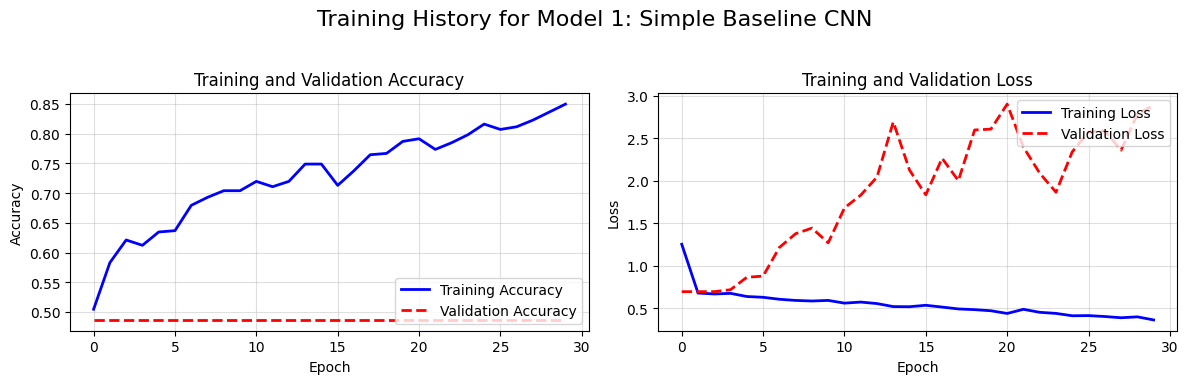

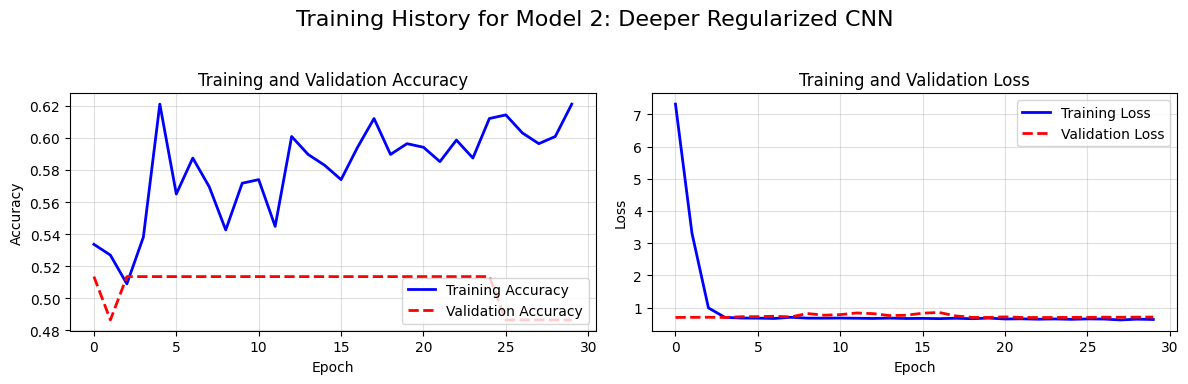


Training history plots generated. Analyze the difference between the two models for overfitting!


In [39]:
# =================================================================
# COLAB CELL 7: Plotting Training History
# =================================================================

print("--- CELL 7: Plotting Training and Validation Metrics ---")

def plot_training_history(history, model_name):
    """Plots the training and validation loss and accuracy."""

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc)) # Number of epochs trained

    plt.figure(figsize=(12, 4))
    plt.suptitle(f'Training History for {model_name}', fontsize=16)

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', color='blue', linewidth=2)
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='red', linestyle='--', linewidth=2)
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(alpha=0.4)

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', color='blue', linewidth=2)
    plt.plot(epochs_range, val_loss, label='Validation Loss', color='red', linestyle='--', linewidth=2)
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(alpha=0.4)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- Execute Plotting ---
plot_training_history(history_1, "Model 1: Simple Baseline CNN")
plot_training_history(history_2, "Model 2: Deeper Regularized CNN")

print("\nTraining history plots generated. Analyze the difference between the two models for overfitting!")


--- CELL 8: Generating Confusion Matrices ---

--- Evaluating Model 1 (Simple CNN) ---
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


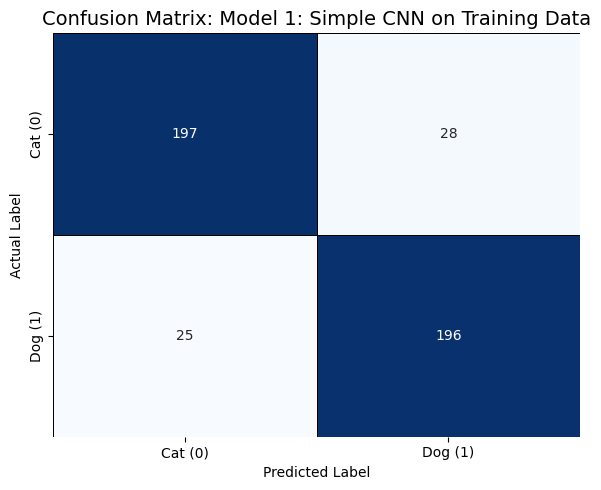

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


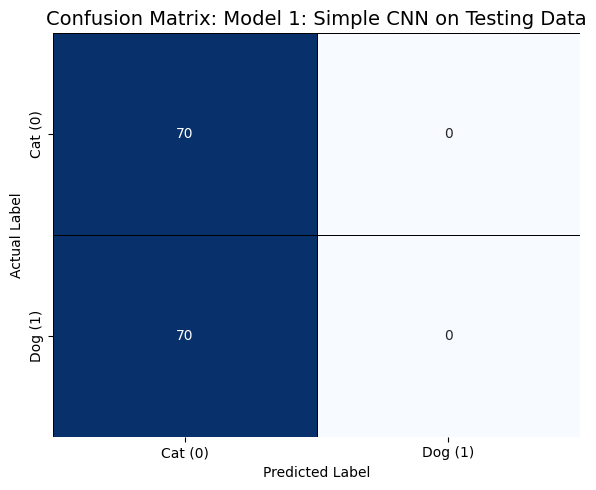


--- Evaluating Model 2 (Regularized CNN) ---
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


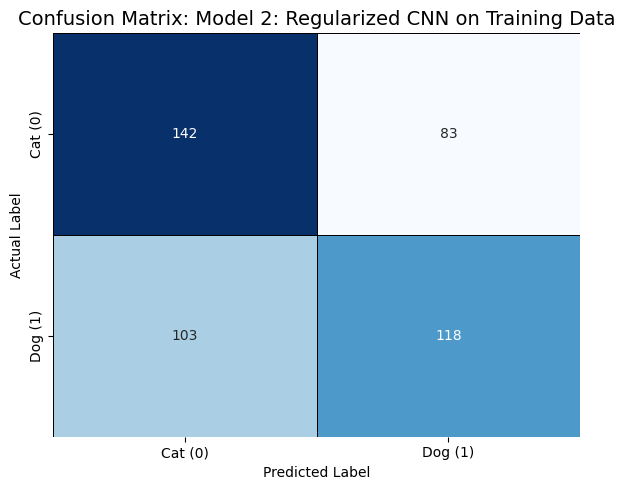

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


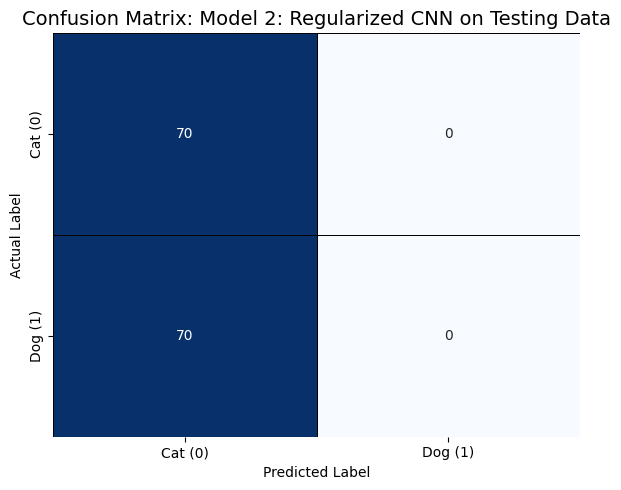


All confusion matrices generated. Compare the True Positives (bottom right) and True Negatives (top left) for both models, particularly on the Testing Data.


In [40]:
# NOTE: The following variables are assumed to be defined from previous steps:
# model_1, model_2, train_ds, test_ds

# =================================================================
# COLAB CELL 8: Model Evaluation (Confusion Matrices)
# =================================================================

print("--- CELL 8: Generating Confusion Matrices ---")

def get_true_labels_and_predictions(model, dataset):
    """Generates true labels and binary predictions (0 or 1) for a dataset."""
    # Concatenate all batches into a single array
    true_labels = np.concatenate([y for x, y in dataset], axis=0)

    # Get predictions (probabilities)
    probabilities = model.predict(dataset)

    # Convert probabilities to binary predictions (0 or 1) using a threshold of 0.5
    predictions = (probabilities > 0.5).astype(int).flatten()

    return true_labels, predictions

def plot_confusion_matrix(cm, model_name, dataset_name):
    """Plots a confusion matrix using seaborn."""

    plt.figure(figsize=(6, 5))
    # '0' corresponds to the first class ('cats') and '1' to the second ('dogs')
    labels = ['Cat (0)', 'Dog (1)']

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels, cbar=False,
                linewidths=0.5, linecolor='black')

    plt.title(f'Confusion Matrix: {model_name} on {dataset_name}', fontsize=14)
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# --- Evaluation for Model 1 ---
print("\n--- Evaluating Model 1 (Simple CNN) ---")

# Train Confusion Matrix for Model 1
y_true_train_1, y_pred_train_1 = get_true_labels_and_predictions(model_1, train_ds)
cm_train_1 = confusion_matrix(y_true_train_1, y_pred_train_1)
plot_confusion_matrix(cm_train_1, "Model 1: Simple CNN", "Training Data")

# Test Confusion Matrix for Model 1
y_true_test_1, y_pred_test_1 = get_true_labels_and_predictions(model_1, test_ds)
cm_test_1 = confusion_matrix(y_true_test_1, y_pred_test_1)
plot_confusion_matrix(cm_test_1, "Model 1: Simple CNN", "Testing Data")


# --- Evaluation for Model 2 ---
print("\n--- Evaluating Model 2 (Regularized CNN) ---")

# Train Confusion Matrix for Model 2
y_true_train_2, y_pred_train_2 = get_true_labels_and_predictions(model_2, train_ds)
cm_train_2 = confusion_matrix(y_true_train_2, y_pred_train_2)
plot_confusion_matrix(cm_train_2, "Model 2: Regularized CNN", "Training Data")

# Test Confusion Matrix for Model 2
y_true_test_2, y_pred_test_2 = get_true_labels_and_predictions(model_2, test_ds)
cm_test_2 = confusion_matrix(y_true_test_2, y_pred_test_2)
plot_confusion_matrix(cm_test_2, "Model 2: Regularized CNN", "Testing Data")

print("\nAll confusion matrices generated. Compare the True Positives (bottom right) and True Negatives (top left) for both models, particularly on the Testing Data.")
